# <center> PyABC games

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
import math
sys.path.append('..')  # add parent directory to path to import utils
from utils import set_plots_size_params
import pyabc
import os
import scipy.stats as st
import pandas as pd

In [2]:
def wf_with_selection_and_mutation(wt_freq, population_size, fitness, mutation_rate, sequence_sample_size):
    # math from https://academic.oup.com/sysbio/article/66/1/e30/2670014#syw056M2 
    wt_freq = (wt_freq * fitness) / ( (1-wt_freq) + (wt_freq * fitness))                 # selection
    wt_freq = wt_freq*(1 - mutation_rate) + (1 - wt_freq)*mutation_rate                  # mutation
    wt_freq = np.random.binomial(population_size, wt_freq) / population_size             # drift
    wt_freq = np.random.binomial(sequence_sample_size, wt_freq) / sequence_sample_size   # bottleneck
    return wt_freq
    
    
def wt_generations(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                   color=None, label=None, plot=True):
    freqs = []
    for i in range(generations_number):
        wt_freq = wf_with_selection_and_mutation(wt_freq=wt_freq, population_size=population_size, 
                                                 fitness=fitness, mutation_rate=mutation_rate, 
                                                 sequence_sample_size=sequence_sample_size)
        freqs.append(wt_freq)
    if plot:
        plt.plot(range(generations_number), freqs, color=color, label=label, alpha=0.1)
    return np.array(freqs)


def simulate_50(generations_number, wt_freq, population_size, fitness, mutation_rate, sequence_sample_size, 
                 color=None, label=None, plot=True):
    plt.xlabel('Generation')
    plt.ylabel('Frequency')
    data = []
    for i in range(50):
        datum = wt_generations(generations_number=generations_number, wt_freq=wt_freq, plot=plot,
                               population_size=population_size, fitness=fitness, mutation_rate=mutation_rate, 
                               color=color,  sequence_sample_size=sequence_sample_size, 
                               label=label if i==0 else None)
        data.append(datum)
    if label:
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    return pd.DataFrame(data)

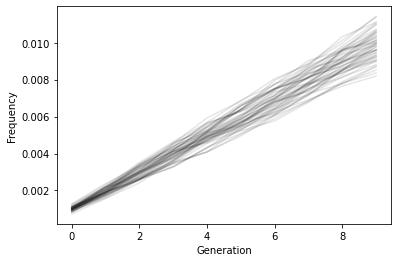

In [4]:
pop_size = 100000000
gen_num = 10
fitness = 1
mutation_rate = 0.001
sample_size = 100000
intial_freq = 0
data = simulate_50(generations_number=gen_num, wt_freq=intial_freq, population_size=pop_size,
                             fitness=fitness, mutation_rate=mutation_rate, sequence_sample_size=sample_size, 
                             color='black').mean()

In [8]:
def pyFITS(prior_dist, data, simulation_num, params, top_fraction):
    values = []
    for i in range(simulation_num):
        prior = 10**prior_dist.rvs()['x']
        sym = wt_generations(mutation_rate=prior, generations_number=params['gen'], wt_freq=params['freq0'], 
                             population_size=params['pop'], fitness=params['fit'], 
                             sequence_sample_size=params['ss'], plot=False)
        distance = abs(sym-data).sum()
        values.append({'distance': distance, 'post': prior})
    df = pd.DataFrame.from_records(values).sort_values('distance')
    df = df.head(int(simulation_num * top_fraction))
    df['log_post'] = np.log10(df['post'])
    return df

In [19]:
def run_pyFITS(log_prior, data, num_sim, top_fraction, model_params):
    print(f"Running {num_sim} simulations, accepting top {top_fraction}")
    post = pyFITS(log_prior, data, num_sim, model_params, top_fraction)
    print(f"Created posterior from {len(post)} results")
    print(f"max epsilon: {post.distance.max()}")
    plt.hist(post['log_post'])
    plt.show()
    return post

In [11]:
def smc_model(parameter):
    pop_size = 100000000
    gen_num = 10
    fitness = 1
    sample_size = 100000
    intial_freq = 0
    mutation_rate = 10**parameter['x']
    return {'a': wt_generations(generations_number=gen_num,  wt_freq=intial_freq, population_size=pop_size, 
                          mutation_rate=mutation_rate, fitness=fitness, sequence_sample_size=sample_size, 
                          plot=False, color=False, label=False)}

In [12]:
def plot_smc(smc_out):
    fig, ax = plt.subplots()
    for t in range(smc_out.max_t+1):
        df, w = smc_out.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df, w,
            x="x", ax=ax,
            label="PDF t={}".format(t))
    ax.legend(bbox_to_anchor=(1, 1))
    plt.show()


In [13]:
def last_freq_L1(simulation, data):
    return abs(data['a'] - simulation['a']).sum()


def run_smc(priors, data, epsilon):
    abc = pyabc.ABCSMC(
            smc_model, parameter_priors,
            last_freq_L1, population_size=1000)
    db_path = ("sqlite:///test.db")
    smc_post = abc.new(db_path, {'a': data})
    smc_post = abc.run(minimum_epsilon=epsilon, max_nr_populations=10)
    plot_smc(smc_post)
    return smc_post

In [27]:
def plot_kdes(smc_output, pyFITS_output, real_value):
    real_value = math.log10(real_value)
    fig, ax = plt.subplots()
    df, w = smc_output.get_distribution(m=0)
    pyabc.visualization.plot_kde_1d(
        df, w, 
        x="x", ax=ax,
        label="ABCSMC")
    ax.axvline(10**real_value, color="k", linestyle="dashed")
    pyabc.visualization.plot_kde_1d(
        pyFITS_output, np.ones(len(pyFITS_output))/len(pyFITS_output), label='pyFITS', x='log_post', ax=ax)
    ax.axvline(real_value, color="k", linestyle="dashed")
    plt.title('Posterior')
    plt.legend()

In [28]:
def compare_pyFITS(mutation_rate, prior_edges, num_sim, top_fraction):
    params = {'gen': 10, 'freq0':0, 'pop': 100000000, 'ss': 100000, 'fit': 1}
    data = simulate_50(generations_number=params['gen'], wt_freq=params['freq0'],  mutation_rate=mutation_rate,
                       population_size=params['pop'], fitness=params['fit'], sequence_sample_size=params['ss'], 
                             plot=False).mean()
    prior_dist = pyabc.Distribution(x=pyabc.RV("uniform", prior_edges[0], prior_edges[1]-prior_edges[0]))
    fits_out = run_pyFITS(prior_dist, data, num_sim, top_fraction, params)
    epsilon = fits_out['distance'].max()
    smc_out = run_smc(prior_dist, data, epsilon)
    plot_kdes(smc_out, fits_out, mutation_rate)
    

Running 100000 simulations, accepting top 0.01
Created posterior from 1000 results
max epsilon: 0.0013389999999999995


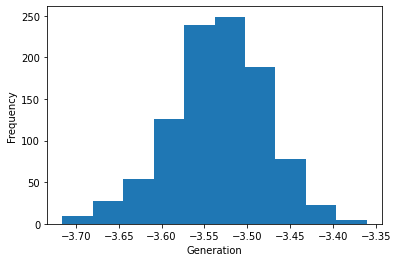

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=103, start_time=2020-12-30 19:51:07.286654, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.016179
INFO:ABC:t: 0, eps: 0.016179.
INFO:ABC:Acceptance rate: 1000 / 2042 = 4.8972e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.014618999999999998.
INFO:ABC:Acceptance rate: 1000 / 2258 = 4.4287e-01, ESS=9.7584e+02.
INFO:ABC:t: 2, eps: 0.010146883984843778.
INFO:ABC:Acceptance rate: 1000 / 2070 = 4.8309e-01, ESS=9.9366e+02.
INFO:ABC:t: 3, eps: 0.005679291925256538.
INFO:ABC:Acceptance rate: 1000 / 2137 = 4.6795e-01, ESS=9.9442e+02.
INFO:ABC:t: 4, eps: 0.0029508816956800078.
INFO:ABC:Acceptance rate: 1000 / 2169 = 4.6104e-01, ESS=9.4081e+02.
INFO:ABC:t: 5, eps: 0.0017111064518877627.
INFO:ABC:Acceptance rate: 1000 / 2950 = 3.3898e-01, ESS=7.6849e+02.
INFO:ABC:t: 6, eps: 0.001168384763468661.
INFO:ABC:Acceptance rate: 1000 / 5267 = 1.8986e-01, ESS=5.9887e+02.
INFO:ABC:Stopping

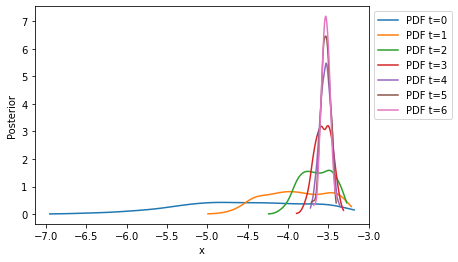

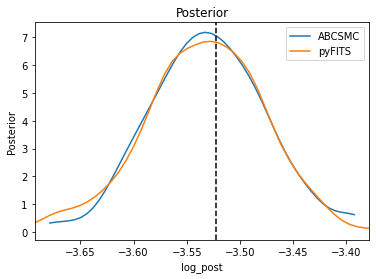

In [31]:
compare_pyFITS(0.0003, [-7,-2], 100000, 0.01)

Running 10000 simulations, accepting top 0.01
Created posterior from 100 results
max epsilon: 0.009254000000000002


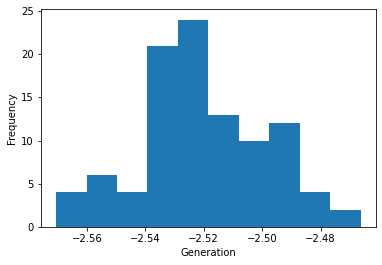

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=102, start_time=2020-12-30 19:50:17.048245, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.16169099999999997
INFO:ABC:t: 0, eps: 0.16169099999999997.
INFO:ABC:Acceptance rate: 1000 / 1955 = 5.1151e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.146636.
INFO:ABC:Acceptance rate: 1000 / 2113 = 4.7326e-01, ESS=9.6522e+02.
INFO:ABC:t: 2, eps: 0.10129191766824355.
INFO:ABC:Acceptance rate: 1000 / 2049 = 4.8804e-01, ESS=9.9680e+02.
INFO:ABC:t: 3, eps: 0.05687881838929385.
INFO:ABC:Acceptance rate: 1000 / 1957 = 5.1099e-01, ESS=9.9736e+02.
INFO:ABC:t: 4, eps: 0.029048843214691793.
INFO:ABC:Acceptance rate: 1000 / 1981 = 5.0480e-01, ESS=9.9971e+02.
INFO:ABC:t: 5, eps: 0.014973783767660957.
INFO:ABC:Acceptance rate: 1000 / 1934 = 5.1706e-01, ESS=9.9501e+02.
INFO:ABC:t: 6, eps: 0.007606400000000004.
INFO:ABC:Acceptance rate: 1000 / 2377 = 4.2070e-01, ESS=8.4466e+02.
INFO:ABC:St

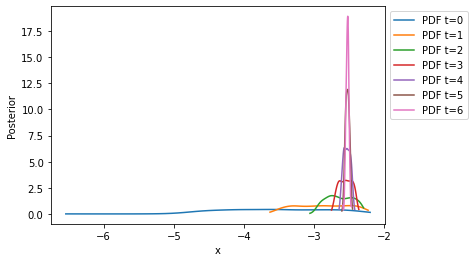

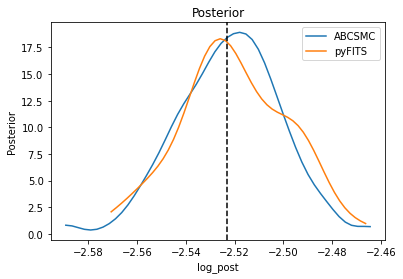

In [30]:
compare_pyFITS(0.003, [-7,-2], 10000, 0.01)

Running 100000 simulations, accepting top 0.01
Created posterior from 1000 results
max epsilon: 0.0002262


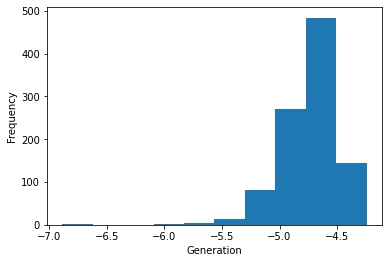

INFO:Sampler:Parallelizing the sampling on 8 cores.
INFO:History:Start <ABCSMC(id=101, start_time=2020-12-30 19:40:58.908894, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.0011790000000000001
INFO:ABC:t: 0, eps: 0.0011790000000000001.
INFO:ABC:Acceptance rate: 1000 / 1894 = 5.2798e-01, ESS=1.0000e+03.
INFO:ABC:t: 1, eps: 0.001119.
INFO:ABC:Acceptance rate: 1000 / 2109 = 4.7416e-01, ESS=9.4372e+02.
INFO:ABC:t: 2, eps: 0.000799.
INFO:ABC:Acceptance rate: 1000 / 2329 = 4.2937e-01, ESS=9.5488e+02.
INFO:ABC:t: 3, eps: 0.0004830831845858169.
INFO:ABC:Acceptance rate: 1000 / 2977 = 3.3591e-01, ESS=8.7057e+02.
INFO:ABC:t: 4, eps: 0.0003313999999999999.
INFO:ABC:Acceptance rate: 1000 / 4802 = 2.0825e-01, ESS=4.1256e+02.
INFO:ABC:t: 5, eps: 0.0002596525250161071.
INFO:ABC:Acceptance rate: 1000 / 10283 = 9.7248e-02, ESS=3.0989e+02.
INFO:ABC:t: 6, eps: 0.00022020000000000004.
INFO:ABC:Acceptance rate: 1000 / 17840 = 5.6054e-02, ESS=5.8107e+02.
INFO:ABC:S

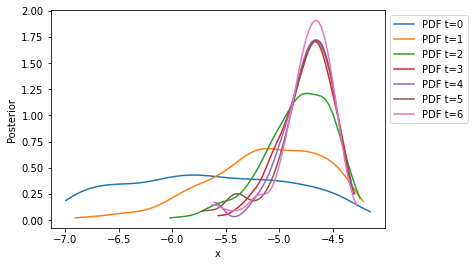

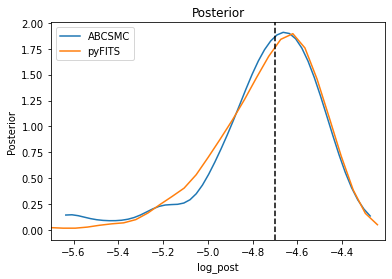

In [29]:
compare_pyFITS(0.00002, [-7,-2], 100000, 0.01)

In [ ]:
THE END!

# From here onwards its legacy code! Continue at your own risk!

In [ ]:
fits = dict()
fits['mut'] = pd.DataFrame(data={'freq': data.mean()})
fits['wt'] = pd.DataFrame(data={'freq': 1-data.mean()})
fits['mut']['allele'] = 1
fits['wt']['allele'] = 0
fits_input = pd.concat(fits.values()).reset_index().rename(columns={'index': 'gen'})
fits_input=fits_input[['gen','allele','freq']]
#fits_input.to_csv('fits_input_01.tsv', index=False, sep='\t')

In [ ]:
data.mean().values

In [ ]:
fits_post = pd.read_table('../FITS/posterior.txt')
#narr_pri = pd.read_table('../FITS/post_narrow_prior.txt')
bottle_post = pd.read_table('../FITS/post_bottle.tsv')
fits_mil = pd.read_table('../FITS/post_mil.tsv')

In [ ]:
epsilon = fits_post.distance.max()
epsilon

In [ ]:
post_01 = pd.read_table('../FITS/post_01.tsv')
post_01['log'] = np.log10(post_01['allele0_1'])

In [ ]:
epsilon = post_01.distance.max()
epsilon

In [ ]:
def estimate_post_in_point(point):
    post = 0
    for i in range(1000):
        syn_data = model({'x':point})
        dist = last_freq_L1(syn_data, {'a': y_observed})
        if dist < epsilon:
            post += 1
    return post

In [ ]:
post = []
rates = []
start= -4
for i in range(100):
    rate = start + (i/100)
    rates.append(round(rate,3))
    post.append(estimate_post_in_point(rate))

In [ ]:
plt.plot(post)

In [ ]:
test = pd.DataFrame.from_dict(data=post, orient='index')

In [ ]:
plt.hist(post)

In [ ]:
post

In [ ]:
history.total_nr_simulations


In [ ]:
observation = mutation_rate
fig, ax = plt.subplots()
for t in range(history.max_t+1):
    df, w = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=-5, xmax=-2,
        x="x", ax=ax,
        label="PDF t={}".format(t))
ax.axvline(observation, color="k", linestyle="dashed")
ax.legend(bbox_to_anchor=(1, 1))


In [ ]:
fits_mil['log'] = np.log10(fits_mil['allele0_1'])

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-4, xmax=-3,
    x="x", ax=ax,
    label="ABCSMC".format(t))
ax.axvline(10**observation, color="k", linestyle="dashed")
"""pyabc.visualization.plot_kde_1d(
    fits_post, np.ones(1000)/1000, label='FITS', x='log',
    xmin=-4, xmax=-3, ax=ax)
"""
pyabc.visualization.plot_kde_1d(
    fits_mil, np.ones(10000)/10000, label='FITS-million', x='log',
    xmin=-4, xmax=-3, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
asdasd

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-3.5, xmax=-2.5,
    x="x", ax=ax,
    label="ABCSMC")
ax.axvline(-3, color="k", linestyle="dashed")
pyabc.visualization.plot_kde_1d(
    post_01, np.ones(10000)/10000, label='FITS-01', x='log',
    xmin=-3.5, xmax=-2.5, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
# TODO: build wrapper and compare different mutation rates and params

In [ ]:
narr_pri['log'] = np.log10(narr_pri['allele0_1'])

In [ ]:
bottle_post['log'] = np.log10(bottle_post['allele0_1'])

In [ ]:
fits_post.distance.max()

In [ ]:
fits_post['log'] = np.log10(fits_post['allele0_1'])

In [ ]:
fits_post['log'].min(),fits_post['log'].max()

In [ ]:
df['x'].min(),df['x'].max()

In [ ]:
len(w)

In [ ]:
len(fits_post['log'])

In [ ]:
fits_post

In [ ]:
fig, ax = plt.subplots()
df, w = history.get_distribution(m=0)
pyabc.visualization.plot_kde_1d(
    df, w, 
    xmin=-4, xmax=-3,
    x="x", ax=ax,
    label="ABCSMC".format(t))
ax.axvline(observation, color="k", linestyle="dashed")
"""pyabc.visualization.plot_kde_1d(
    fits_post, np.ones(1000)/1000, label='FITS', x='log',
    xmin=-4, xmax=-3, ax=ax)
"""
pyabc.visualization.plot_kde_1d(
    bottle_post, np.ones(1000)/1000, label='FITS-bottle', x='log',
    xmin=-4, xmax=-3, ax=ax)
#plt.plot(test.rate, test.freq/60, label='Model')   # <--- ignore the height this is just to normalize.
plt.title('Posterior')
plt.legend()

In [ ]:
test = pd.DataFrame(data={'rate': rates, 'freq': post})

In [ ]:
test.loc[50]

In [ ]:
plt.plot(test.rate, test.freq/50)

In [ ]:
pyabc.visualization.plot_kde_1d(
    test, np.ones(100), label='FITS-narrow', x='rate',
    xmin=-4, xmax=-3)


In [ ]:
plt.hist(df.x, weights=w)


In [ ]:
plt.hist(fits_post.log)
#fits_post.log.hist()

In [ ]:
def sample_over_threshold(x, eps, min_prior, max_prior):
    res = []
    for i in range(10000):
        y = np.random.uniform(min_prior,max_prior)
        if abs(y - x) < eps:
            res.append(y)
    return res

In [ ]:
narrow_sample = sample_over_threshold(1000, 10, 900, 1100)
wide_sample = sample_over_threshold(1000, 10, 0, 2000)

In [ ]:
plt.hist(wide_sample)

In [ ]:
plt.hist(narrow_sample)

In [ ]:
min(narrow_sample), max(narrow_sample)

In [ ]:
min(wide_sample), max(wide_sample)

In [ ]:
np.random.uniform(990,1010)

In [ ]:
np.random.uniform(0,2000)

In [ ]:
fits_post['allele0_1']

In [ ]:
sns.kdeplot(fits_post['allele0_1'])
plt.axvline(observation, color="k", linestyle="dashed");

In [ ]:
fits_post.distance.hist()

In [ ]:
fits_post.distance.mean()

In [ ]:
fits_post['allele1_0'].max()

In [ ]:
fits_post['allele1_0'].min()

In [ ]:
import seaborn as sns
sns.kdeplot(history.get_distribution(m=0)[1])
plt.axvline(observation, color="k", linestyle="dashed");

In [ ]:
observation

In [ ]:
plt.hist(history.get_distribution(m=0)[1], )

In [ ]:
samples, weights = history.get_distribution(m=0)
samples.hist(weights=weights)
print(np.average(samples.x, weights=weights))

In [ ]:
adasdasd

In [ ]:
samples.hist()

In [ ]:
sns.kdeplot(samples.x, weights=weights)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
samples_, weights_ = history.get_distribution(m=0)
pyabc.visualization.plot_kde(
    samples_, weights_, ax=ax)
"""ax.plot(μ, σ, '*', color=color_truth)
ax.plot(μ_hat, σ_hat, '*', color=color_estimate)
"""

In [ ]:
samples.x

In [ ]:
np.average(samples.x, weights=weights)


In [ ]:
import seaborn as sns
sns.boxplot(samples)

In [ ]:
samples.x.std()

In [ ]:
history.get_distribution(m=1)

In [ ]:
model(mutation_rate=mutation_rate)[9]

In [ ]:
np.mean(model(mutation_rate=mutation_rate))

In [ ]:
set_plots_size_params(20)

In [ ]:
sigma = .5

def model(parameters):
    # sample from a gaussian
    y = st.norm(parameters.x, sigma).rvs()
    # return the sample as dictionary
    return {"y": y}

models = [model, model]


# However, our models' priors are not the same.
# Their mean differs.
mu_x_1, mu_x_2 = 0, 1
parameter_priors = [
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),
    pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
]
abc = pyabc.ABCSMC(
    models, parameter_priors,
    pyabc.PercentileDistance(measures_to_use=["y"]))
# y_observed is the important piece here: our actual observation.
y_observed = 1
# and we define where to store the results
db_path = ("sqlite:///test.db")
history = abc.new(db_path, {"y": y_observed})


In [ ]:
# We run the ABC until either criterion is met
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)


In [ ]:
model_probabilities = history.get_model_probabilities()
model_probabilities
